In [1]:
from fastai import *
from fastai.vision import *
#from fastai.widgets import 
from torch.nn import CrossEntropyLoss

In [2]:
#!kaggle competitions download -c datasciencebowl -p {plankton_path}  
#!unzip {path}/sampleSubmission.csv.zip
#!unzip {path}/test.zip
#!unzip {path}/train.zip

In [3]:
plankton_path = Config.data_path()/'plankton'
train_path = plankton_path / 'train'
test_path = plankton_path / 'test'
project_path = pathlib.Path.home()/'PROJEX/competitions_1/plankton'

In [4]:
project_path.exists()

True

In [5]:
train_path.exists(), test_path.exists()

(True, True)

In [6]:
df_sub = pd.read_csv(plankton_path/'sampleSubmission.csv')

In [7]:
df_sub.head(1).T

,0
image,1.jpg
acantharia_protist_big_center,0.00826446
acantharia_protist_halo,0.00826446
acantharia_protist,0.00826446
amphipods,0.00826446
appendicularian_fritillaridae,0.00826446
appendicularian_s_shape,0.00826446
appendicularian_slight_curve,0.00826446
appendicularian_straight,0.00826446
artifacts_edge,0.00826446


In [8]:
df_sub.head(1).T[1:].sum()

0    1.0
dtype: float64

It appears that the goal is to produce a csv file with 1 row per image, and columns populated by classes. For a given image, each class is assigned a probability. 

## Data Dealings

The training data set is partitioned into folders names after the classes they belonged to. The table above 122 classes.
The widget FileDeleter was removed in favor of ImageDeleter and ImageRelabeler.



In [9]:
Categories = [cat.name for cat in train_path.glob('*')]

In [10]:
Categories

['copepod_other',
 'hydromedusae_solmundella',
 'trichodesmium_tuft',
 'hydromedusae_shapeA',
 'chaetognath_sagitta',
 'shrimp_zoea',
 'copepod_calanoid_flatheads',
 'crustacean_other',
 'protist_dark_center',
 'invertebrate_larvae_other_A',
 'hydromedusae_typeE',
 'echinoderm_larva_seastar_bipinnaria',
 'detritus_filamentous',
 'radiolarian_colony',
 'copepod_calanoid_eggs',
 'copepod_calanoid_octomoms',
 'fish_larvae_thin_body',
 'tunicate_doliolid',
 'hydromedusae_shapeA_sideview_small',
 'siphonophore_calycophoran_sphaeronectes_young',
 'ctenophore_lobate',
 'copepod_cyclopoid_copilia',
 'siphonophore_partial',
 'artifacts',
 'polychaete',
 'siphonophore_calycophoran_sphaeronectes',
 'hydromedusae_typeD',
 'copepod_calanoid_large_side_antennatucked',
 'detritus_other',
 'unknown_unclassified',
 'protist_fuzzy_olive',
 'chaetognath_non_sagitta',
 'copepod_calanoid',
 'tunicate_doliolid_nurse',
 'siphonophore_calycophoran_abylidae',
 'appendicularian_s_shape',
 'fish_larvae_very_thin

In [11]:
test = ImageList.from_folder(test_path)
data = (ImageDataBunch.from_folder(train_path, train='./', valid_pct=0.2,
                                   ds_tfms=get_transforms(), size=224)
        .normalize(imagenet_stats))

In [12]:
data.classes[:5]

['acantharia_protist',
 'acantharia_protist_big_center',
 'acantharia_protist_halo',
 'amphipods',
 'appendicularian_fritillaridae']

In [13]:
for c in data.classes:
    verify_images(train_path/c, )

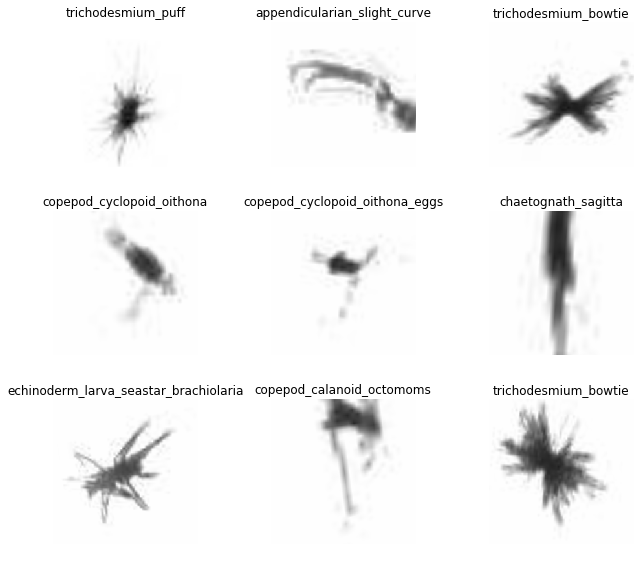

In [14]:
data.show_batch(rows=3, figsize=(9, 8))

In [15]:
data.c, len(data.train_ds), len(data.valid_ds)

(121, 24269, 6067)

### Train model

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.loss_func = CrossEntropyLoss()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


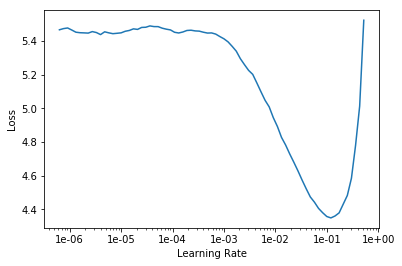

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.085551,1.554326,0.431844,01:56
1,1.625188,1.244018,0.365419,01:59
2,1.445843,1.111777,0.331795,01:59
3,1.322459,1.073278,0.324048,01:59


In [20]:
learn.save(project_path / 'stage-1')

In [21]:
stat = (project_path/'stage-1.pth').stat()

In [22]:
print(f'model size: {stat.st_size/int(1e6):.2f}MB')

model size: 92.50MB


---
## LEFT OFF HERE
---

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.confusion_matrix()

In [39]:
img = learn.data.train_ds[0][0]

In [41]:
a = learn.predict(img)

In [42]:
a[]

(Category detritus_filamentous,
 tensor(34),
 tensor([2.0350e-04, 6.2076e-05, 6.8971e-05, 8.8474e-03, 7.5911e-04, 1.7384e-02,
         1.4034e-02, 8.9387e-03, 3.9106e-04, 6.9520e-05, 1.3150e-03, 4.5805e-02,
         5.5944e-03, 9.2401e-04, 9.4332e-03, 5.0444e-02, 6.5228e-04, 9.7584e-03,
         4.0127e-03, 3.6956e-03, 2.0148e-03, 6.5648e-04, 2.7261e-03, 1.4107e-04,
         5.4129e-03, 1.4026e-03, 7.7352e-04, 5.2806e-02, 9.3115e-05, 1.6513e-04,
         1.6593e-04, 1.4412e-04, 7.4799e-02, 4.2862e-02, 1.3678e-01, 4.1145e-02,
         8.3842e-04, 1.4975e-03, 1.1959e-03, 8.0050e-04, 1.2018e-03, 6.1808e-03,
         4.9632e-04, 3.6899e-04, 2.5929e-04, 2.4789e-04, 1.5323e-04, 1.1178e-02,
         9.3716e-03, 5.3646e-02, 1.5390e-03, 7.6943e-04, 7.1770e-03, 7.8706e-03,
         1.1784e-02, 4.8762e-03, 1.2975e-04, 4.5173e-04, 1.3977e-04, 3.0336e-04,
         9.5391e-05, 2.3030e-04, 1.1699e-04, 2.6137e-04, 3.2061e-04, 3.8287e-05,
         2.0835e-04, 1.5081e-04, 1.2488e-04, 2.2914e-04, 2.4663e

In [20]:
doc(ImageCleaner)

## Post learning data cleaning

ImageDeleter is essentially the same as the old FileDeleter.

ImageRelabeler renders the files you pass in and lets you re-label them. This is to find mis-categorized images in your data directory. NOTE: ImageRelabeler currently only works with files where labels were created from the names of their parent directory (i.e. with .from_folder()). The widget moves mislabeled photos from the incorrect parent directory to the properly-labeled parent directory.

To relabel an image, just click the proper label in the widget dropdown.

Both widgets take a formatted dataset from DatasetFormatter. You can easily specify which dataset you’d like to render by passing in DatasetType.Valid, DatasetType.Train or DatasetType.Test to the ds_type keyword arg in DatasetFormatter.from_toplosses.

All three classes are available in fastai.widgets.